<a href="https://colab.research.google.com/github/deekshitha16/pneumonia-detection-on-x_ray-image/blob/master/Pnemonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# run the drive if the images are stored in the drive
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

In [0]:
# import all the required libraries
import numpy as np
import os, shutil
import cv2
import glob
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
# using pathlib library to save the path directory in the 'train path'
train_path = Path('/content/drive/My Drive/chest_xray/chest_xray/train')

In [0]:
# getting the subdirectory folders from train path 
normal_cases_dir = train_path/'NORMAL'
pneumonia_cases_dir = train_path/'PNEUMONIA'

In [0]:
# glob function is used to get  path of all the images in the pneumonia and normal directories
normal_cases = normal_cases_dir.glob('*.jpeg')
phneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

In [0]:
'''lets create a train_data list which as a tuple value (image path , label)
 if the label = 1 - indicates person is pneumonia affected, label =0 indicates
 person is normal'''

train_data = []

for img in normal_cases:
  train_data.append((img, 0))

for img in phneumonia_cases:
  train_data.append((img, 1))  


In [0]:
# creating a dataframe 'train_data for image dataset using pandas library

train_data = pd.DataFrame(train_data, columns=['image','label'])

In [0]:
# The dataframe with label-0 as 'Normal' and label-1 as 'Phneumonia'

train_data.head()

,image,label
0,/content/drive/My Drive/chest_xray/chest_xray/...,0
1,/content/drive/My Drive/chest_xray/chest_xray/...,0
2,/content/drive/My Drive/chest_xray/chest_xray/...,0
3,/content/drive/My Drive/chest_xray/chest_xray/...,0
4,/content/drive/My Drive/chest_xray/chest_xray/...,0


In [0]:
# the dataset is embalanced, the count of label 1 =2534 and count of label 0 = 1341
train_data['label'].value_counts()

1    2534
0    1341
Name: label, dtype: int64

In [0]:
seed =123
np.random.seed(seed)

In [0]:
# lets shuffle the dataset 

train_data = train_data.sample(frac=1.).reset_index(drop=True)


In [0]:
train_data.head()


,image,label
0,/content/drive/My Drive/chest_xray/chest_xray/...,1
1,/content/drive/My Drive/chest_xray/chest_xray/...,1
2,/content/drive/My Drive/chest_xray/chest_xray/...,1
3,/content/drive/My Drive/chest_xray/chest_xray/...,1
4,/content/drive/My Drive/chest_xray/chest_xray/...,1


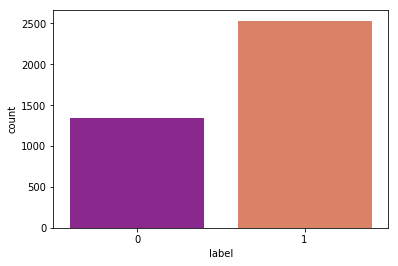

In [0]:
# from countplot we can see that there is unequal distribution of labels in the dataset

sns.countplot(train_data['label'], palette='plasma')

To balance the data, i have created a subdirectoty in the train_path as 'pneumonia_balanced' which stores only 1341 images, here i have performed down sampling as 70% of the data as label 1 and 30% of the data as label 0, upsampling might cause overfitting 


In [0]:
src = '/content/drive/My Drive/chest_xray/chest_xray/train/PNEUMONIA'
dst = '/content/drive/My Drive/chest_xray/chest_xray/train/pneumonia_blanced'

In [0]:
# code for moving the file from one directory to another directory
 
'''
for f in os.listdir('/content/drive/My Drive/chest_xray/chest_xray/train/PNEUMONIA')[:1341]:
  src_name = os.path.join(src, f)
  shutil.copy(src_name,'/content/drive/My Drive/chest_xray/chest_xray/train/pneumonia_blanced/.jpeg')
  
'''  




"\nfor f in os.listdir('/content/drive/My Drive/chest_xray/chest_xray/train/PNEUMONIA')[:1341]:\n src_name = os.path.join(src, f)\n shutil.copy(src_name,'/content/drive/My Drive/chest_xray/chest_xray/train/pneumonia_blanced/.jpeg')\n \n"

In [0]:
# getting the subdirectory folders from train path, performing similar operation as above
normal_dir = train_path/'NORMAL'
phenumonia_dir = train_path/'pneumonia_blanced'

normal_case = normal_dir.glob('*.jpeg')
phenumonia_case = phenumonia_dir.glob('*.jpeg')

In [0]:
'''lets create a train_data list which as a tuple value (image path , label)
 if the label = 1 - indicates person is pneumonia affected, label =0 indicates
 person is normal'''
new_train_data =[]

for img in normal_case:
  new_train_data.append((img,0))

for img in phenumonia_case:
  new_train_data.append((img,1))

In [0]:
# creating the dataframe to store the balanced label
df = pd.DataFrame(new_train_data, columns=['image','label'], dtype=str)
df = df.reindex(np.random.permutation(df.index))

In [0]:
df.head()

,image,label
2091,/content/drive/My Drive/chest_xray/chest_xray/...,1
1190,/content/drive/My Drive/chest_xray/chest_xray/...,0
617,/content/drive/My Drive/chest_xray/chest_xray/...,0
1567,/content/drive/My Drive/chest_xray/chest_xray/...,1
2492,/content/drive/My Drive/chest_xray/chest_xray/...,1


In [0]:
df['label'].value_counts()

1    1342
0    1341
Name: label, dtype: int64

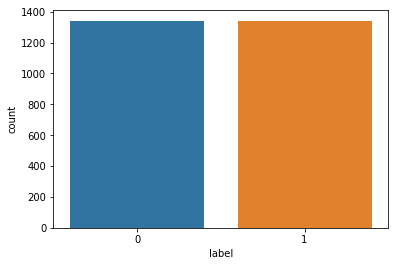

In [0]:
# the above figure shows the balanced classification of 'PHEUMONIA' and 'NORMAL'
sns.countplot(df['label'])

In [0]:
df.dtypes

image    object
label    object
dtype: object

In [0]:
os.listdir(train_path)

['PNEUMONIA', 'NORMAL', '.DS_Store', 'pneumonia_blanced']

In [0]:
# lets build the model
# here i will be using vgg16 pretrainded model, u can use any other model of your choice
# lets import vgg16 library and weights used here is imagenet weights

image_size = [224,224]

vgg = VGG16(input_shape = image_size+[3], weights = 'imagenet', include_top = False)

W0829 04:49:09.937493 140712416814976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 04:49:09.982725 140712416814976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 04:49:09.991335 140712416814976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 04:49:10.045461 140712416814976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 1s 0us/step


W0829 04:49:11.571085 140712416814976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0829 04:49:11.572208 140712416814976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [0]:
# here i am not training the model again in the sense not updating the weights of the model, using  the old pretrained model weights 
for layer in vgg.layers:
  layer.trainable = False

In [0]:
# now lets create a dense layer for predicting output

x = Flatten()(vgg.output)

x = Dense(128, activation='relu', name='fc1')(x)
x = Dropout(rate = 0.2, name='dropout1')(x)
prediction = Dense(2, activation='softmax', name='output_layer')(x)


model = Model(inputs = vgg.input , outputs = prediction)

W0829 04:49:12.227035 140712416814976 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

W0829 04:49:12.277845 140712416814976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
# path for validation and testing data

valid_path = '/content/drive/My Drive/chest_xray/chest_xray/val'
test_path  = '/content/drive/My Drive/chest_xray/chest_xray/test'

In [0]:
''' for training set i have used dataframe which as equal distribution of categories,
suppose if your using dataframe make sure to convert data type of the column to string type
else it will throw an error '''

data_gen = ImageDataGenerator(rescale=1./255)

training_set = data_gen.flow_from_dataframe(dataframe = df,
                                x_col = 'image',
                                y_col = 'label',
                                target_size=(224,224),
                                class_mode='categorical',
                                batch_size=128,
                                shuffle = True,
                                seed = 1)

Found 2683 validated image filenames belonging to 2 classes.


In [0]:
# testing data to check my model performance on unseen data
test_set = data_gen.flow_from_directory(directory = test_path,
                                              target_size = (224,224),
                                              batch_size = 64,
                                              color_mode = 'rgb',
                                              class_mode = 'categorical')                                
                                                                                                                         

Found 624 images belonging to 2 classes.


In [0]:

# now fit the model 

'''using EarlyStopping for preventing overfitting and stop the epochs if there is 
no progress in the validation accuracy, will check after every 3 epochs, by setting patience=3  

Also using modelcheckpoints to restore best weights'''

mc = ModelCheckpoint(filepath = 'lung-disease.{epoch:02d} - {val_loss:.2f}.hdf5',
                     monitor = 'val_acc',
                     save_best_only = True,
                     save_weights_only = True,
                     mode = 'max',
                     period = 3)
                     
                     
monitor = EarlyStopping(monitor = 'val_loss',
                        min_delta = 1e-3,
                        patience = 2,
                        restore_best_weights = False,
                        verbose = 1,
                        mode = 'min')                        

hist = model.fit_generator(generator = training_set,
                    steps_per_epoch = len(training_set),
                    validation_data = test_set,
                    validation_steps = len(test_set),
                    epochs = 10,
                    callbacks = [monitor,mc])

W0829 04:49:15.124917 140712416814976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
21/21 [==============================] - 1774s 84s/step - loss: 1.0637 - acc: 0.6459 - val_loss: 0.4721 - val_acc: 0.8558
Epoch 2/10
21/21 [==============================] - 1705s 81s/step - loss: 0.2883 - acc: 0.9031 - val_loss: 0.3272 - val_acc: 0.8606
Epoch 3/10
21/21 [==============================] - 1705s 81s/step - loss: 0.1769 - acc: 0.9386 - val_loss: 0.3121 - val_acc: 0.8782
Epoch 4/10
21/21 [==============================] - 1707s 81s/step - loss: 0.1430 - acc: 0.9538 - val_loss: 0.3612 - val_acc: 0.8526
Epoch 5/10
21/21 [==============================] - 1705s 81s/step - loss: 0.1129 - acc: 0.9628 - val_loss: 0.3545 - val_acc: 0.8686
Epoch 00005: early stopping


In [0]:
#lets save the training model performance in h5 file 
import tensorflow as tf
from keras.models import load_model
model.save('lung_disease_vgg16.h5')


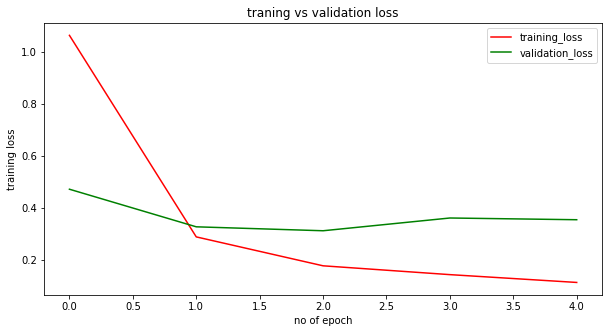

<Figure size 432x288 with 0 Axes>

In [0]:

# lets plot the graph for accuracy and loss

# plot for training and validation loss

plt.figure(figsize=(10,5)) 
plt.plot(hist.history['loss'], label = 'training_loss', color = 'red')
plt.plot(hist.history['val_loss'] , label = 'validation_loss',  color = 'green')
plt.legend()
plt.xlabel('no of epoch')
plt.ylabel('training loss')
plt.title('traning vs validation loss')
plt.show()
plt.savefig('tran_val_loss')

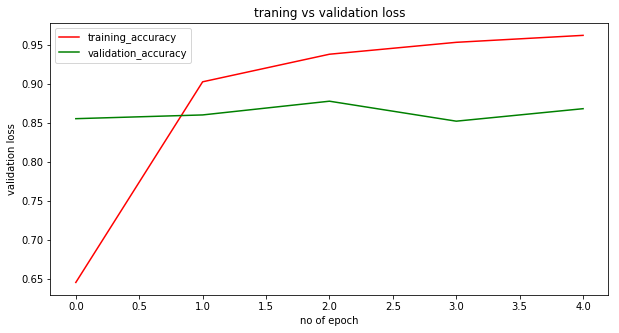

<Figure size 432x288 with 0 Axes>

In [0]:
# plot for training and validation accuracy

plt.figure(figsize=(10,5))
plt.plot(hist.history['acc'], label = 'training_accuracy', color = 'red')
plt.plot(hist.history['val_acc'] , label = 'validation_accuracy', color = 'green')
plt.legend()
plt.xlabel('no of epoch')
plt.ylabel('validation loss')
plt.title('traning vs validation loss')
plt.show()
plt.savefig('tran_val_accuracy')


In [146]:
# now lets predict the model on validation set
validation_set = data_gen.flow_from_directory(directory = valid_path,
                                              target_size = (224,224),
                                             batch_size = 16,
                                              class_mode = 'categorical')                      

Found 16 images belonging to 2 classes.


In [147]:
validation_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [0]:
y_pred = model.predict_generator(generator = validation_set,
                                  steps = 1,
                                 verbose = 0)

In [151]:
# getting the labels for validation set
test_img , test_labels = next(validation_set)
test_labels

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [163]:
# evaluate the model
test_loss, test_accuracy = model.evaluate_generator(validation_set,
                         steps = 1)

print('test_loss', test_loss)
print('test_accuracy', test_accuracy)

test_loss 0.19922414422035217
test_accuracy 0.9375


In [165]:
# predicted class labels
y_test = np.argmax(y_pred,axis =-1)
y_test

array([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1])

In [177]:
# actual class labels
y_actual = np.argmax(test_labels , axis=-1)
y_actual

array([0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1])

In [0]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

<Figure size 864x576 with 0 Axes>

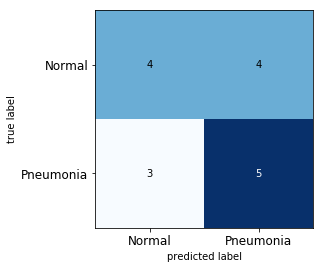

In [168]:
# Get the confusion matrix
cm  = confusion_matrix(y_actual, y_test)
plt.figure(figsize=(12,8))
plot_confusion_matrix(cm, hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=12)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=12)
plt.show()

In [169]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.62
Precision of the model is 0.56


In [179]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_test))

              precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.56      0.62      0.59         8

    accuracy                           0.56        16
   macro avg       0.56      0.56      0.56        16
weighted avg       0.56      0.56      0.56        16

